<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros... 

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

**Grupo 26**

María Candelaria Arpajou

Hugo Alberto Folonier

Gustavo Jaca

# 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [5]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [6]:
from sklearn.cluster import KMeans,MeanShift,DBSCAN
from sklearn import decomposition

# 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [7]:
#url='https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset'
#df=pd.read_csv(url)
df_completo=pd.read_csv('players_22.csv')
df_completo.head(5)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [8]:
print(df_completo.columns)
print(len(df_completo.columns), 'variables')

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)
110 variables


In [9]:
df = df_completo.copy()
df = df.drop(['player_url','dob','club_jersey_number','club_loaned_from','club_joined',
              'club_contract_valid_until','player_tags','player_traits',
              'work_rate','body_type','real_face','player_face_url',
              'club_logo_url','club_flag_url','nation_logo_url','nation_flag_url'],axis=1)
print(df.columns)
print(len(df.columns), 'variables')

Index(['sofifa_id', 'short_name', 'long_name', 'player_positions', 'overall',
       'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'club_team_id', 'club_name', 'league_name', 'league_level',
       'club_position', 'nationality_id', 'nationality_name', 'nation_team_id',
       'nation_position', 'nation_jersey_number', 'preferred_foot',
       'weak_foot', 'skill_moves', 'international_reputation',
       'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_sho

In [10]:
print(df.describe())

           sofifa_id       overall     potential     value_eur       wage_eur  \
count   19239.000000  19239.000000  19239.000000  1.916500e+04   19178.000000   
mean   231468.086959     65.772182     71.079370  2.850452e+06    9017.989363   
std     27039.717497      6.880232      6.086213  7.613700e+06   19470.176724   
min        41.000000     47.000000     49.000000  9.000000e+03     500.000000   
25%    214413.500000     61.000000     67.000000  4.750000e+05    1000.000000   
50%    236543.000000     66.000000     71.000000  9.750000e+05    3000.000000   
75%    253532.500000     70.000000     75.000000  2.000000e+06    8000.000000   
max    264640.000000     93.000000     95.000000  1.940000e+08  350000.000000   

                age     height_cm     weight_kg   club_team_id  league_level  \
count  19239.000000  19239.000000  19239.000000   19178.000000  19178.000000   
mean      25.210822    181.299704     74.943032   50580.498123      1.354364   
std        4.748235      6.863

In [11]:
df2 = pd.DataFrame()
df2 = df.copy()
pp = df2["player_positions"].str.split(',',expand=True)
pp.columns = ['player_positions1','player_positions2','player_positions3']
df2 = pd.concat([df2,pp], axis=1)
df2 = df2.drop(['player_positions'],axis=1)
#df = df2.copy()
df2.head(3)

,sofifa_id,short_name,long_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_positions1,player_positions2,player_positions3
0,158023,L. Messi,Lionel Andrés Messi Cuccittini,93,93,78000000.0,320000.0,34,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,52,Argentina,1369.0,RW,10.0,Left,4,4,5,144300000.0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,RW,ST,CF
1,188545,R. Lewandowski,Robert Lewandowski,92,92,119500000.0,270000.0,32,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,37,Poland,1353.0,RS,9.0,Right,4,4,5,197200000.0,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,ST,None,None
2,20801,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,91,91,45000000.0,270000.0,36,187,83,11.0,Manchester United,English Premier League,1.0,ST,38,Portugal,1354.0,ST,7.0,Right,4,5,5,83300000.0,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,ST,LW,None


**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall") y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [12]:
#n=10000
#df_n=df.loc[:n] #los primeros n
df_n=df2[(df2['overall']>70)] # mejores jugadores

skills_ratings = ['attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')
df_skills=df_n[skills_ratings]

35 variables numéricas: skills/habilidades


In [13]:
df_skills.tail(3) #Entrada, matriz de datos X

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
4590,70,61,49,71,29,71,74,35,69,72,80,82,67,58,65,45,69,73,70,40,50,64,65,59,40,70,68,70,67,12,12,11,15,9,NaN
4591,64,74,72,63,58,66,56,49,57,65,79,74,55,70,75,74,68,65,74,63,70,30,73,59,63,59,35,38,34,14,15,14,12,8,NaN
4592,57,61,54,70,61,71,60,49,74,78,59,62,53,71,55,62,61,78,72,66,72,66,68,71,48,74,64,70,61,13,10,10,6,9,NaN


In [14]:
df_skills.isnull().sum()

attacking_crossing                0
attacking_finishing               0
attacking_heading_accuracy        0
attacking_short_passing           0
attacking_volleys                 0
skill_dribbling                   0
skill_curve                       0
skill_fk_accuracy                 0
skill_long_passing                0
skill_ball_control                0
movement_acceleration             0
movement_sprint_speed             0
movement_agility                  0
movement_reactions                0
movement_balance                  0
power_shot_power                  0
power_jumping                     0
power_stamina                     0
power_strength                    0
power_long_shots                  0
mentality_aggression              0
mentality_interceptions           0
mentality_positioning             0
mentality_vision                  0
mentality_penalties               0
mentality_composure               0
defending_marking_awareness       0
defending_standing_tackle   

Los jugadores que no son arqueros pueden tener goalkeeping_speed=NaN. A estos le asignamos goalkeeping_speed=0.

In [15]:
df_skills = df_skills.fillna(0)
df_skills.isnull().sum()

attacking_crossing             0
attacking_finishing            0
attacking_heading_accuracy     0
attacking_short_passing        0
attacking_volleys              0
skill_dribbling                0
skill_curve                    0
skill_fk_accuracy              0
skill_long_passing             0
skill_ball_control             0
movement_acceleration          0
movement_sprint_speed          0
movement_agility               0
movement_reactions             0
movement_balance               0
power_shot_power               0
power_jumping                  0
power_stamina                  0
power_strength                 0
power_long_shots               0
mentality_aggression           0
mentality_interceptions        0
mentality_positioning          0
mentality_vision               0
mentality_penalties            0
mentality_composure            0
defending_marking_awareness    0
defending_standing_tackle      0
defending_sliding_tackle       0
goalkeeping_diving             0
goalkeepin

**Resumen de los dataframes definidos:**

* df_completo es el dataframe completo sin ningun cambio tal y como fue descargado de Kaggle

* df es el dataframe completo sin las columnas con enlaces web

* df_n es el dataframe df restringido a los jugadores con overall mayor a 70

* df_skills es un dataframe con las 35 skills del dataframe df_n, donde los NaN de df_n fueron reemplazados por el valor numérico cero.


# 3.-Exploración de la base

Lo primero que hacemos es hacer un histograma de cada una de las 35 skills de df_skills

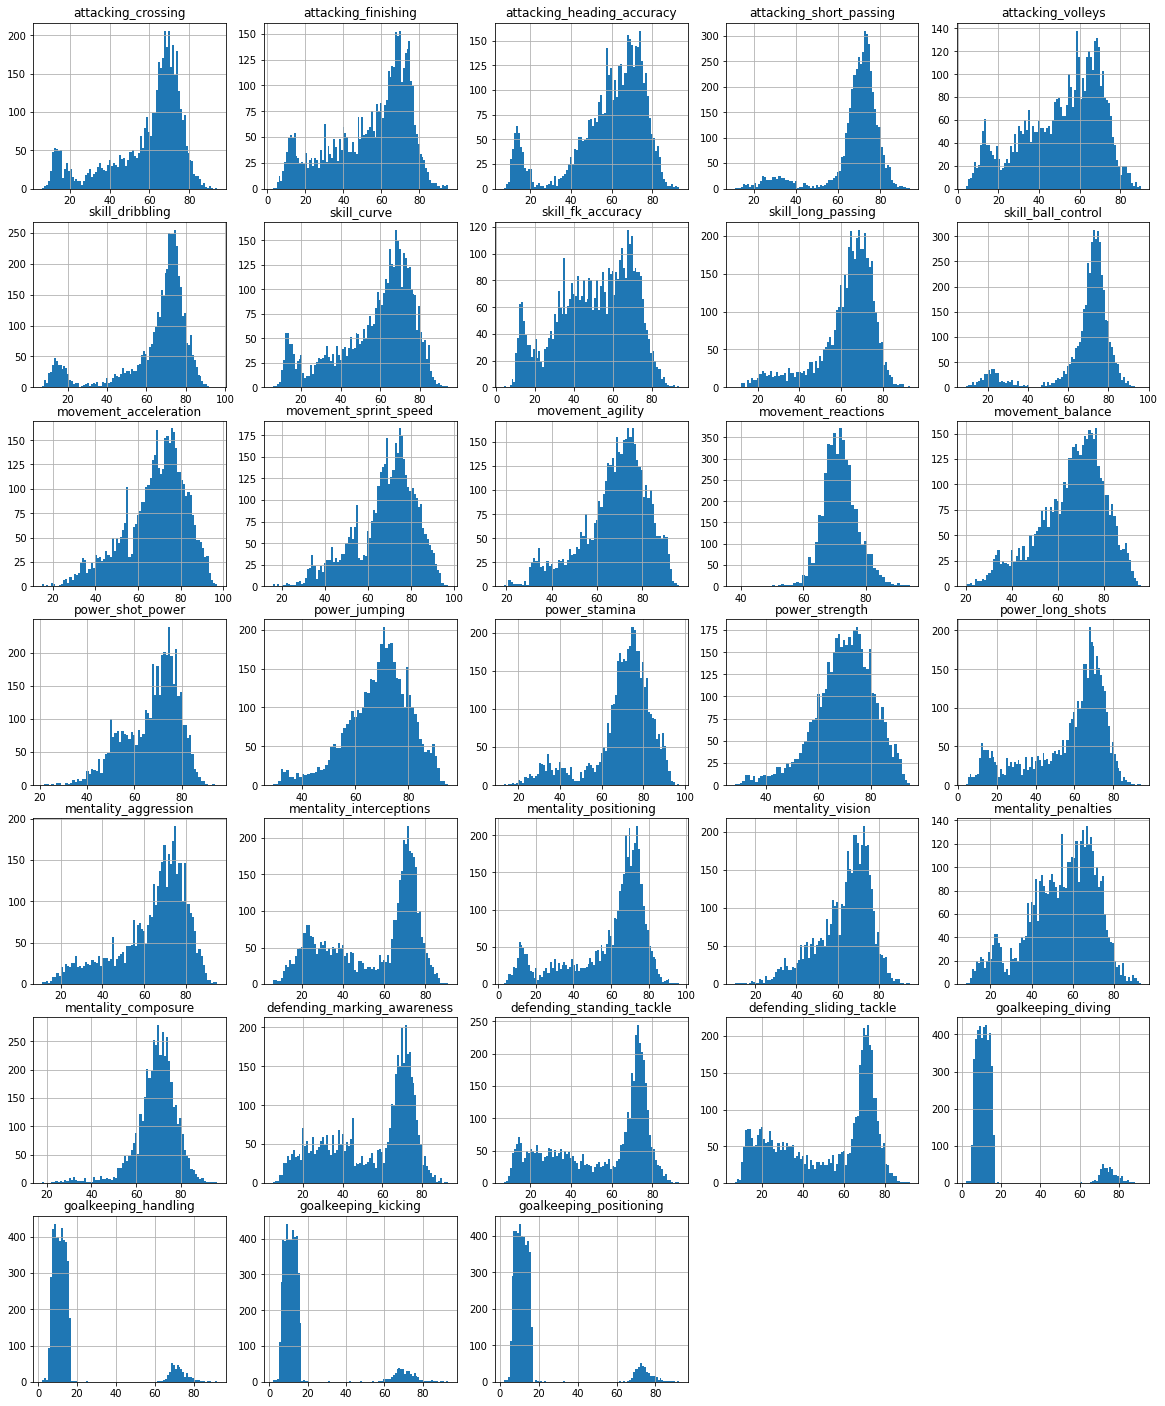

In [16]:
plt.figure(figsize=(20,25))
#nbins=89
i = 0
for feature in ('attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning'):
  i += 1
  plt.subplot(7,5,i)
  nbins=df_skills[feature].max()-df_skills[feature].min()+1
  df_skills[feature].hist(bins = nbins)  
  plt.title(feature)

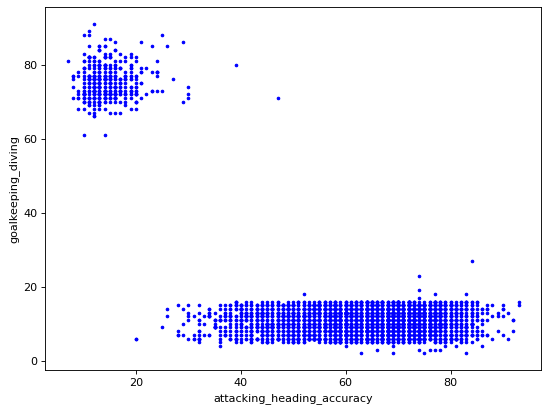

In [17]:
#Elejimos dos variables, para esto elegimos dos números entre 0 y 34 de df_skills
skill_1=skills_ratings[2]
skill_2=skills_ratings[29]

#Graficamos
plt.figure(figsize=(8,6), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=5,c='blue',cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Lo que nos muestran estos gráficos es que al menos existen dos clases muy diferentes que se corresponden a los arqueros y a los jugadores de campo. Esto es fácil de inferir porque todas las skills que empiezan por 'goalkeeping_', son skills propias de los arqueros y de ningun otro jugador de campo. Por lo tanto, sería interesante en algun momento realizar el analisis y el clustering a las dos poblaciones separadamente. Para eso definimos 4 nuevos dataframes: df_n_arq, df_n_cam, df_skills_arq y df_skills_cam usando la condicion 'goalkeeping_diving' > 40 para separar ambos casos

In [18]:
df_n_arq=df_n[(df_n['goalkeeping_diving']>40)] # df_n solo con arqueros
df_n_cam=df_n[(df_n['goalkeeping_diving']<40)] # df_n sin los arqueros
df_skills_arq = df_n_arq[skills_ratings]       # df_skills solo con arqueros
df_skills_cam = df_n_cam[skills_ratings]       # df_skills sin los arqueros
df_skills_cam = df_skills_cam.fillna(0)

Ahora repetimos los histogramas usando los df_skills_arq y df_skills_cam separadamente.

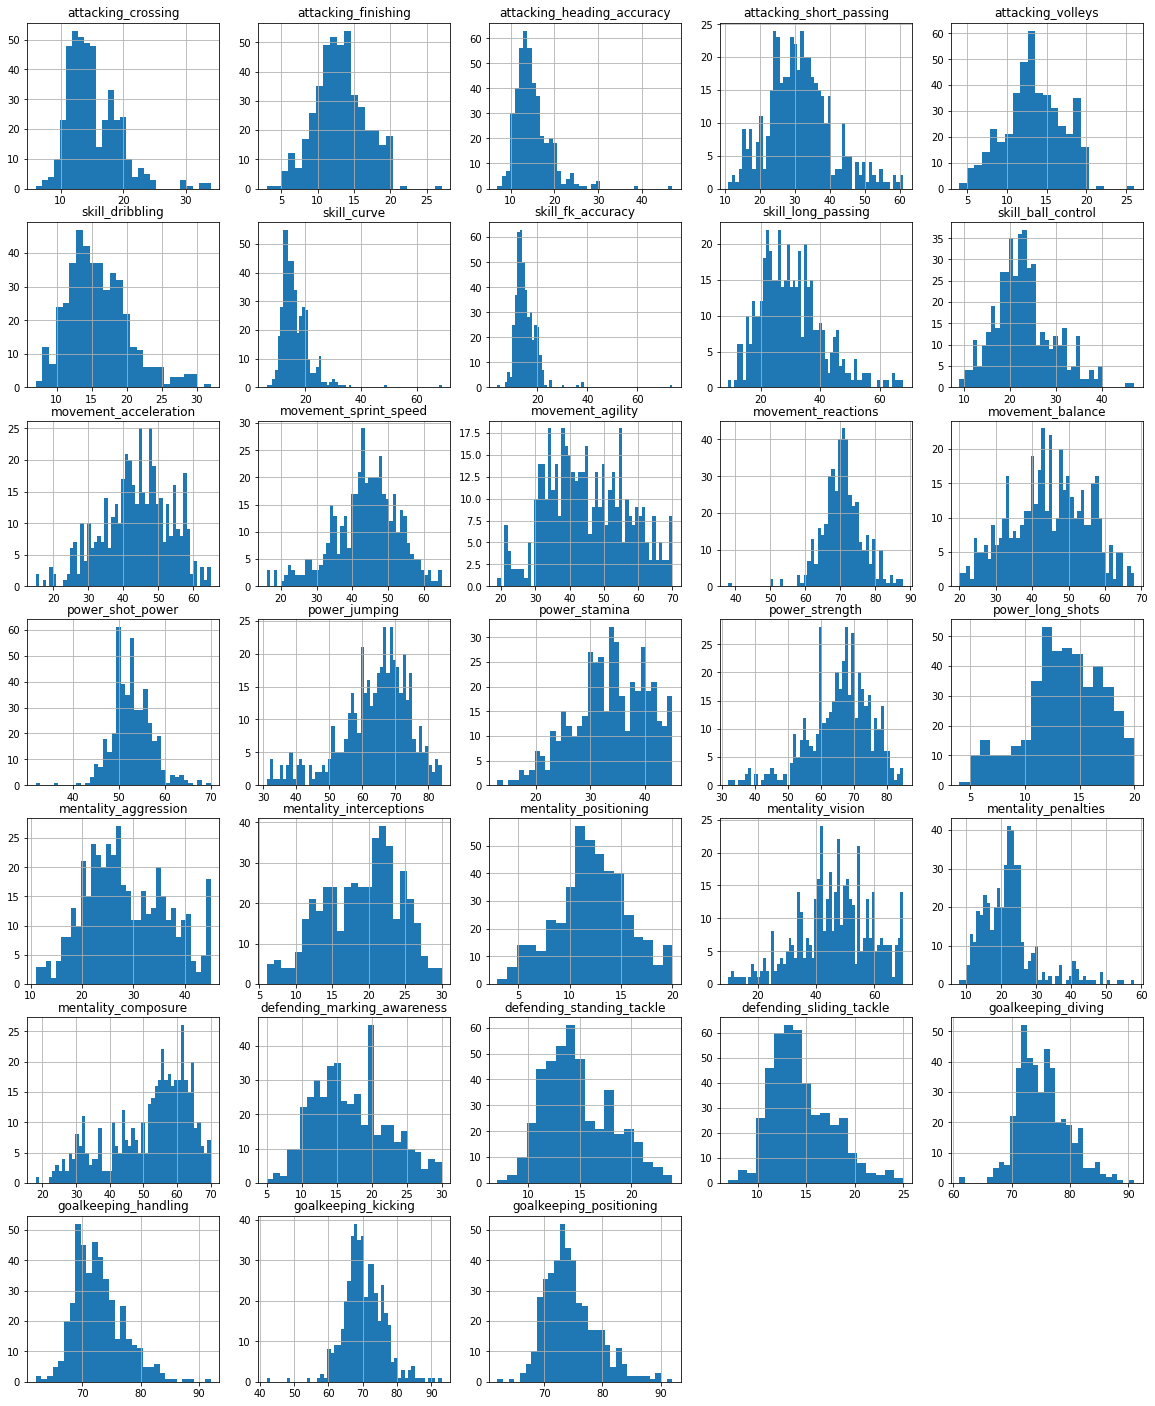

In [19]:
plt.figure(figsize=(20,25))
i = 0
for feature in ('attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning'):
  i += 1
  plt.subplot(7,5,i)
  nbins=df_skills_arq[feature].max()-df_skills_arq[feature].min()+1
  df_skills_arq[feature].hist(bins = nbins)  
  plt.title(feature)

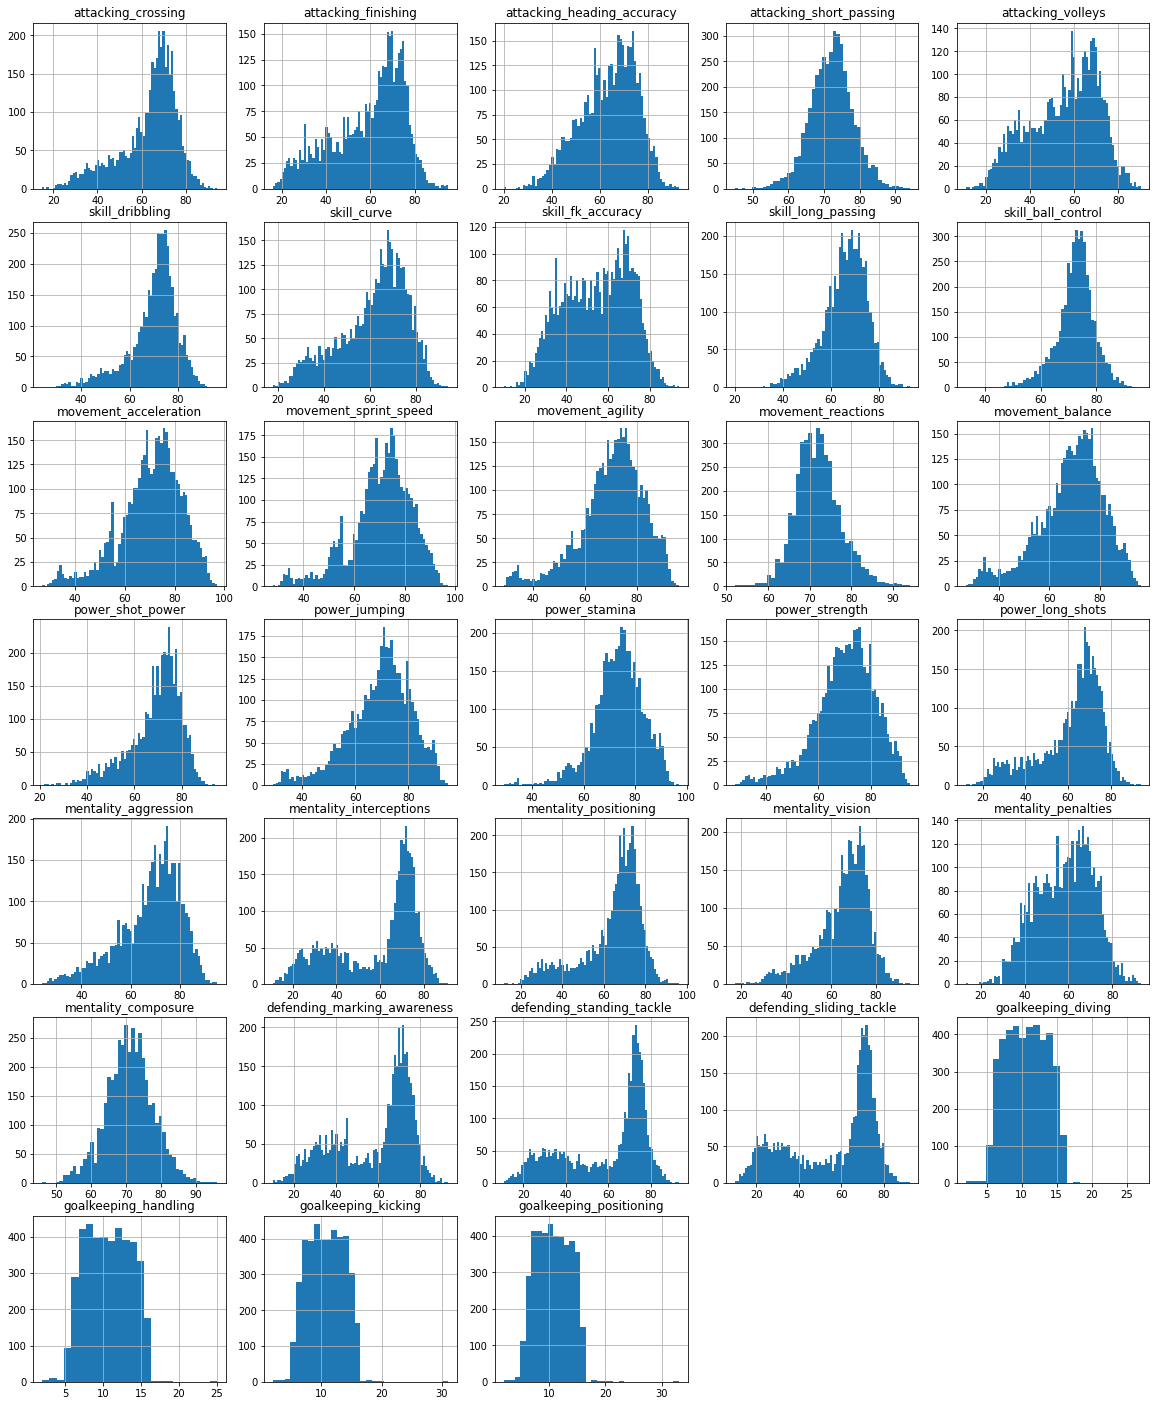

In [20]:
plt.figure(figsize=(20,25))
i = 0
for feature in ('attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning'):
  i += 1
  plt.subplot(7,5,i)
  nbins=df_skills_cam[feature].max()-df_skills_cam[feature].min()+1
  df_skills_cam[feature].hist(bins = nbins)  
  plt.title(feature)

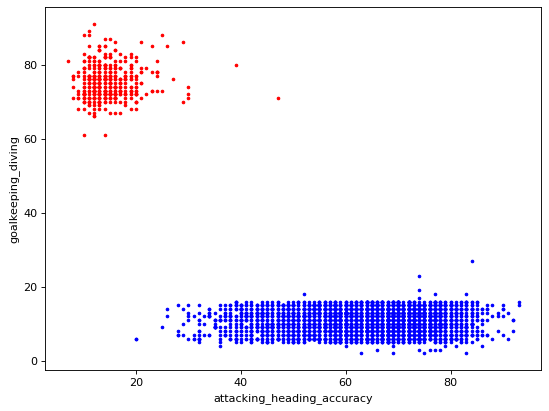

In [21]:
#Elejimos dos variables, para esto elegimos dos números entre 0 y 35 de df_skills_arq y df_skills_cam
skill_1=skills_ratings[2]
skill_2=skills_ratings[29]

#Graficamos
plt.figure(figsize=(8,6), dpi=80)
plt.scatter(df_skills_arq[skill_1], y=df_skills_arq[skill_2],s=5,c='red',cmap='jet')
plt.scatter(df_skills_cam[skill_1], y=df_skills_cam[skill_2],s=5,c='blue',cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Podemos observar que para los arqueros, muchas de sus habilidades solo toman valores muy bajos. Por ejemplo, la habilidad attacking_finishing es menor de 30 para todo el dataframe de arqueros. Usando algun criterio, podemos prescindir de estas habilidades en el momento de hacer clustering, haciendo una reducción de dimensionalidad. Esto tambien se puede aplicar para el dataframe de jugadores de campo. Haciendo un describe de estos dataframes, podemos escojer un criterio.

In [22]:
df_skills_arq.describe()

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,14.970721,12.963964,14.711712,31.277027,13.326577,15.801802,15.977477,14.871622,30.168919,22.860360,43.873874,43.754505,45.324324,70.779279,44.527027,52.972973,63.860360,33.727477,65.801802,13.666667,28.520270,19.015766,12.220721,46.750000,21.921171,52.220721,17.103604,14.761261,14.398649,75.301802,72.666667,70.439189,74.500000,76.813063,43.799550
std,4.323963,3.606310,4.250375,9.296584,3.825673,4.567171,5.531722,4.858188,10.701610,6.537501,9.882942,9.306208,11.836480,5.940330,10.677361,4.441157,10.845867,6.877192,9.663241,3.702439,8.128596,5.432718,3.676651,12.877023,7.934301,11.994014,5.475831,3.483821,3.317115,4.455336,4.443441,5.906602,4.609589,4.547091,9.275707
min,6.000000,3.000000,7.000000,11.000000,4.000000,7.000000,6.000000,4.000000,9.000000,9.000000,15.000000,16.000000,19.000000,38.000000,20.000000,32.000000,31.000000,13.000000,32.000000,4.000000,11.000000,6.000000,3.000000,10.000000,8.000000,18.000000,5.000000,7.000000,7.000000,61.000000,62.000000,42.000000,62.000000,63.000000,15.000000
25%,12.000000,11.000000,12.000000,25.000000,11.000000,13.000000,12.000000,12.000000,22.000000,19.000000,38.000000,38.000000,36.000000,67.000000,37.000000,50.000000,58.000000,30.000000,60.000000,12.000000,22.000000,15.000000,10.000000,40.000000,16.000000,44.000000,13.000000,12.000000,12.000000,72.000000,69.000000,67.000000,71.000000,74.000000,38.000000
50%,14.000000,13.000000,14.000000,31.000000,13.000000,15.000000,15.000000,14.000000,29.000000,22.000000,45.000000,44.000000,44.000000,71.000000,45.000000,53.000000,66.000000,34.000000,67.000000,14.000000,27.000000,20.000000,12.000000,47.000000,21.500000,55.500000,17.000000,14.000000,14.000000,75.000000,72.000000,70.000000,74.000000,76.000000,44.000000
75%,18.000000,15.000000,16.000000,36.000000,16.000000,18.250000,18.250000,17.000000,36.000000,26.000000,51.000000,50.000000,55.000000,74.000000,53.000000,56.000000,71.000000,39.250000,72.000000,17.000000,35.000000,23.000000,15.000000,55.000000,24.000000,62.000000,20.250000,17.000000,16.250000,78.000000,75.000000,74.000000,77.000000,79.000000,50.000000
max,34.000000,27.000000,47.000000,61.000000,26.000000,32.000000,69.000000,74.000000,68.000000,47.000000,65.000000,65.000000,70.000000,88.000000,68.000000,70.000000,84.000000,45.000000,85.000000,20.000000,45.000000,30.000000,20.000000,70.000000,58.000000,70.000000,30.000000,24.000000,25.000000,91.000000,92.000000,93.000000,92.000000,90.000000,65.000000


In [23]:
df_skills_cam.describe()

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.0
mean,63.201494,58.811762,63.623283,72.156423,55.462762,69.993492,61.864305,54.527597,66.139793,72.684743,70.618703,70.852736,70.642082,71.998554,68.736081,69.145095,69.545915,73.749096,70.458906,61.440347,67.971077,58.425404,64.292119,65.336708,58.268739,70.991564,58.204146,59.041456,55.782357,10.509038,10.587129,10.597734,10.552904,10.511931,0.0
std,13.289735,16.474623,11.968137,6.058567,15.607495,10.231067,14.810134,16.011222,9.346395,6.894291,12.505532,12.154810,12.335646,5.552762,12.867098,11.182331,12.143295,9.746792,11.608657,15.098060,12.813198,19.358418,14.558547,11.863563,13.219581,6.833195,18.420200,19.817969,20.502796,3.044388,3.073032,3.072792,3.097952,3.097525,0.0
min,15.000000,16.000000,20.000000,45.000000,11.000000,24.000000,18.000000,10.000000,20.000000,33.000000,27.000000,28.000000,29.000000,52.000000,27.000000,21.000000,29.000000,29.000000,28.000000,12.000000,24.000000,11.000000,12.000000,17.000000,13.000000,46.000000,10.000000,11.000000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0
25%,57.000000,48.000000,55.000000,68.000000,44.000000,66.000000,53.000000,41.000000,61.000000,69.000000,64.000000,65.000000,64.000000,68.000000,62.000000,64.000000,63.000000,68.000000,64.000000,54.000000,61.000000,40.000000,59.000000,59.000000,48.000000,67.000000,42.000000,41.000000,36.000000,8.000000,8.000000,8.000000,8.000000,8.000000,0.0
50%,67.000000,63.000000,65.000000,72.000000,58.000000,72.000000,65.000000,56.000000,67.000000,73.000000,72.000000,72.000000,72.000000,72.000000,70.000000,72.000000,71.000000,74.000000,72.000000,66.000000,70.000000,68.000000,68.000000,68.000000,60.000000,71.000000,66.000000,69.000000,66.000000,11.000000,11.000000,11.000000,10.000000,10.000000,0.0
75%,72.000000,72.000000,73.000000,76.000000,68.000000,76.000000,73.000000,68.000000,73.000000,77.000000,79.000000,79.000000,79.000000,75.000000,77.000000,77.000000,78.000000,80.000000,79.000000,72.000000,77.000000,73.000000,74.000000,74.000000,68.000000,75.000000,73.000000,74.000000,72.000000,13.000000,13.000000,13.000000,13.000000,13.000000,0.0
max,94.000000,95.000000,93.000000,94.000000,90.000000,96.000000,94.000000,94.000000,93.000000,96.000000,97.000000,97.000000,96.000000,94.000000,96.000000,95.000000,95.000000,97.000000,95.000000,94.000000,95.000000,91.000000,96.000000,95.000000,93.000000,96.000000,93.000000,93.000000,92.000000,27.000000,25.000000,31.000000,33.000000,37.000000,0.0


En nuestro caso vamos a utilizar el siguiente criterio: 

- Nos vamos a quedar con todas las habilidades tal que su media sea mayor a 35.

In [24]:
skills_ratings_arq = ['movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_strength',
       'mentality_vision','mentality_composure',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed']

print(len(skills_ratings_arq), 'variables numéricas: skills/habilidades')
df_skills_arq_dimred=df_n_arq[skills_ratings_arq]
df_skills_arq_dimred.head(3)

16 variables numéricas: skills/habilidades


,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_strength,mentality_vision,mentality_composure,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
5,43,60,67,88,49,59,78,78,65,68,87,92,78,90,90,50.0
7,54,60,51,87,35,68,77,80,70,70,88,88,91,89,88,56.0
8,38,50,39,86,43,66,79,78,70,70,88,85,88,88,90,43.0


In [25]:
skills_ratings_cam = ['attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle']

print(len(skills_ratings_cam), 'variables numéricas: skills/habilidades')
df_skills_cam_dimred=df_n_cam[skills_ratings_cam]
df_skills_cam_dimred.head(3)

29 variables numéricas: skills/habilidades


,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24
1,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19
2,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24


- El dataframe de arqueros se redujo a 16 skills

- El dataframe de jugadores de campo se redujo a 29 skills

# 4.-Clustering

En las siguientes subsecciones trabajaremos con el dataframa completo (arqueros + jugadores de campo) df_n y df_skills

## 4.1-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo.

In [26]:
# Número de clusters buscado
n_clust = 4
km = KMeans(n_clusters=n_clust).fit(df_skills) #utiliza todas las habilidades: 35 dimensiones

# Etiquetas asignadas por el algoritmo
clusters = km.labels_
print('Suma de los cuadrados de las distancias al centro de cada cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al centro de cada cluster=Inertia=  11553599.174627902


In [27]:
df_clusters = df_n.copy()
df_clusters['kmeans_4'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
#df_clusters.head(4)

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [28]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"] < 86

#Eligo dos números entre 0 y 35 de df_skills
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [29]:
kmean_clusters = go.Scatter(x=df_n[skill_1], y=df_n[skill_2],
                           mode='markers',
                           text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_n.loc[bool_crack,skill_1], y=df_n.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]
#data=[kmean_clusters]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [30]:
#En Colab:
fig.show(renderer="colab")

Para este grafico utilizamos ploteamos una variable defensiva en funcion de una variable ofensiva. La idea es que un **delantero** tendrá la variable ofensiva muy alta y la defensiva muy baja. Un **defensor**, por el contrario, esperamos que tenga la variable ofensiva muy baja y la defensiva muy alta. Para los **mediocampistas**, en cambio, esperamos valores intermedios ya que no deberian tener tan desarrolladas estas habilidades (sino seria mejores delanteros o defensores, respectivamente). En el caso de los arqueros, al tener habilidades especificas para esta posicion, esperamos que tengan ambas habilidades bajas.

En el grafico vemos como Kmeans separa estas posiciones en cuatro clusters bien definidos. En particular, los arqueros se encuentran bien aislados del resto de los jugadores de campo.

Si agregamos un cluster más, probablemente el cluster de los mediocampistas deberia subdividirse en dos cluster nuevos: uno para los mediocampistas ofensivos y otro para los mediocampistas defensivos.

In [31]:
# Diagrama de posiciones:
#____________________________
#|     |   LS ST RS   |      |
#| LW  |  LF      RF  |   RW |
#|     |______________|      |
#|            CF             |    ^
#|        LAM CAM RAM        |    | A
#|                           |    | t
#|                           |    | a
#|-LM----LCM--CM--RCM-----RM-|    | q
#|                           |    | u
#|                           |    | e
#|        LDM CDM RDM        |    |
#| LWB  ______________   RWB |
#|  LB |              | RB   |
#|     |  LCB CB RCB  |      |
#|_____|______GK______|______|

# forwards:
# ST = delantero centro (ST=stricker)
# LS,RS = left and rigth strickers?
# LF,RF = segundos delanteros
# LW,RW = extremos

# midfielder:
# CF = mediapuntas  (son casi delanteros atrasados)
# LAM,CAM,RAM = mediocentros ofensivos
# LM,RM = mediocampistas laterales
# LCM,CM,RCM = mediocampistas centrales
# LDM,CDM,RDM = mediocampistas defensivos 

# defenders:
# RWB,LWB = carrileros (son defensores que pasan al ataque)
# CB,RCB,LCB = defensores centrales
# RB,LB = defensores laterales

In [32]:
# Creamos una nueva variable categórica de la base recodificando la posición 
# para simplificar el análisis de los resultados de clustering

forwards=['RF','ST','LW','LF','RS','LS','RW']
midfielders=['CF','LAM','CAM','RAM','LM','LCM','CM','RM','RCM','LDM','CDM','RDM']
defenders=['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if position in forwards:
        return 'FW'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in defenders:
        return 'D'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

In [33]:
df_clusters["Position_red4"]=df_clusters["player_positions1"].apply(lambda x: pos2(x))
df_clusters["Position_red4"].value_counts()

MF    1829
D     1485
FW     835
GK     444
Name: Position_red4, dtype: int64

In [34]:
df_sk = pd.DataFrame()
serie = df_clusters.groupby(['Position_red4','kmeans_4']).size()
df_sk = serie.to_frame().reset_index()
df_sk = df_sk.rename(columns={'Position_red4':'posicion_FIFA','kmeans_4':'KM4',0:'suma'})
df_sk

,posicion_FIFA,KM4,suma
0,D,2,650
1,D,3,835
2,FW,0,806
3,FW,2,29
4,GK,1,444
5,MF,0,683
6,MF,2,1046
7,MF,3,100


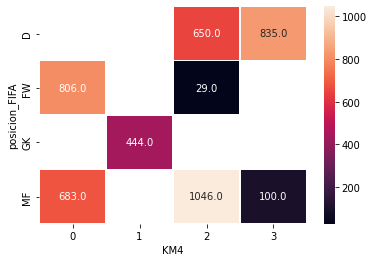

In [35]:
mapa = df_sk.pivot('posicion_FIFA','KM4','suma')
ax = sns.heatmap(mapa, annot=True, fmt="", linewidths=.5)

En este mapa de calor podemos observar que los clusters encontrados reproducen bastante bien las 4 posiciones básicas del juego. Las mayores concentraciones de cada cluster pertenece a una única posición.

Sin embargo podemos observar que una cantidad importante de jugadores que son defensores o mediocampistas, KM los tiende a clasificar como mediocampistas o delanteros, respectivamente.

Para el caso de arqueros y delanteros, KM logra separar muy bien ambos grupos (el número de errores del modelo parece ser muy bajo).

Este grafico puede estar indicandonos que podriamos considerar subdividir al grupo de los mediocampistas en tres subgrupos: mediocampistas defensivos (más ligado a labores defensivas), mediocampistas ofensivos (ligados a labores ofensivas) y mediocampitas (centrales y laterales).

In [36]:
# Número de clusters buscado
n_clust6 = 6
km6 = KMeans(n_clusters=n_clust6).fit(df_skills) #utiliza todas las habilidades: 35 dimensiones
clusters6 = km6.labels_
df_clusters['kmeans_6'] = km6.labels_ #clusters
print('Kmeans encontró: ', max(km6.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  6 clusters, nosotros forzamos la cantidad


In [37]:
#Eligo dos números entre 0 y 35 de df_skills
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

kmean_clusters6 = go.Scatter(x=df_n[skill_1], y=df_n[skill_2],
                           mode='markers',
                           text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters6.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_n.loc[bool_crack,skill_1], y=df_n.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters6,crack]

layout = go.Layout(title="Clustering K means",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [38]:
#En Colab:
fig.show(renderer="colab")

Cuando usamos 6 clusters, puede verse como el cluster de mediocampistas que conectaba los clusters de defensores con el de delanteros, se subdivide en tres nuevos grupos. Uno horizontal en el plano defending-standing-tackle vs. attacking-finishing, correspondiente a los mediocampistas defensivos (tiene valores defensivos altos y skills ofensivas entre medio y altas), y un segundo grupo, vertical en dicho plano, correspondiente a los mediocampistas ofensivos (tiene valores ofensivos altos y skills defensivas entre medio y altas).

In [39]:
# Creamos una nueva variable categórica de la base recodificando la posición 
# para simplificar el análisis de los resultados de clustering

forwards=['LF','RF','LW','RW','LS','RS','ST']
midfielders_of=['CF','LAM','CAM','RAM']
midfielders=['LM','LCM','CM','RCM','RM']
midfielders_def=['LDM','CDM','RDM']
defenders=['LWB','RWB','RCB','CB','LCB','LB','RB']
goalkeepers=['GK']

def pos3(position):
    if position in forwards:
        return 'FW'
    
    elif position in midfielders_of:
        return 'MF_of'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in midfielders_def:
        return 'MF_def'
    
    elif position in defenders:
        return 'D'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

In [40]:
df_clusters["Position_red6"]=df_clusters['player_positions1'].apply(lambda x: pos3(x))
df_clusters["Position_red6"].value_counts()

D         1485
MF         996
FW         835
MF_def     445
GK         444
MF_of      388
Name: Position_red6, dtype: int64

In [41]:
df_sk = pd.DataFrame()
serie = df_clusters.groupby(['Position_red6','kmeans_6']).size()
df_sk = serie.to_frame().reset_index()
df_sk = df_sk.rename(columns={'Position_red6':'posicion_FIFA','kmeans_6':'KM6',0:'suma'})
df_sk

,posicion_FIFA,KM6,suma
0,D,2,664
1,D,4,606
2,D,5,215
3,FW,0,515
4,FW,2,2
5,FW,3,293
6,FW,5,25
7,GK,1,444
8,MF,0,33
9,MF,2,59


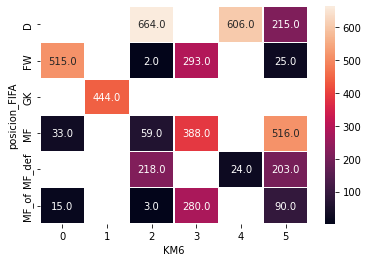

In [42]:
mapa6 = df_sk.pivot('posicion_FIFA','KM6','suma')
ax6 = sns.heatmap(mapa6, annot=True, fmt="", linewidths=.5)

In [43]:
# GK     = 1      |  1
# D      = 4,3,5  |  3
# MF_def = 4,5    |  4
# MF     = 5,0    |  5
# MF_of  = 0      |  0
# FW     = 2,0    |  2

In [44]:
# Vamos a ir a un caso más extremo, con 12 clusters
n_clust12 = 12
km12 = KMeans(n_clusters=n_clust12).fit(df_skills) #utiliza todas las habilidades: 35 dimensiones
clusters12 = km12.labels_
df_clusters['kmeans_12'] = km12.labels_ #clusters
print('Kmeans encontró: ', max(km12.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  12 clusters, nosotros forzamos la cantidad


In [45]:
#Eligo dos números entre 0 y 35 de df_skills
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

kmean_clusters12 = go.Scatter(x=df_n[skill_1], y=df_n[skill_2],
                           mode='markers',
                           text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters12.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_n.loc[bool_crack,skill_1], y=df_n.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters12,crack]

layout = go.Layout(title="Clustering K means",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [46]:
#En Colab:
fig.show(renderer="colab")

In [47]:
# Creamos una nueva variable categórica de la base recodificando la posición 
# para simplificar el análisis de los resultados de clustering

forwards_S=['LS','RS','ST']
forwards_seg=['LF','RF']
forwards_lat=['LW','RW']
midfielders_CF=['CF']
midfielders_A=['LAM','CAM','RAM']
midfielders=['LCM','CM','RCM']
midfielders_lat=['LM','RM']
midfielders_def=['LDM','CDM','RDM']
defenders_car=['LWB','RWB']
defenders_lat=['LB','RB']
defenders=['RCB','CB','LCB']
goalkeepers=['GK']

def pos4(position):
    if position in forwards_S:
        return 'FS'
    
    elif position in forwards_seg:
        return 'FSeg'
    
    elif position in forwards_lat:
        return 'FLat'
    
    elif position in midfielders_CF:
        return 'MCF'
    
    elif position in midfielders_of:
        return 'MA'
    
    elif position in midfielders_lat:
        return 'MLat'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in midfielders_def:
        return 'MD'
    
    elif position in defenders_car:
        return 'DCar'
    
    elif position in defenders_lat:
        return 'DLat'
    
    elif position in defenders:
        return 'D'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

In [48]:
df_clusters["Position_red12"]=df_clusters['player_positions1'].apply(lambda x: pos4(x))
df_clusters["Position_red12"].value_counts()

D       780
DLat    625
FS      623
MF      499
MLat    497
MD      445
GK      444
MA      332
FLat    212
DCar     80
MCF      56
Name: Position_red12, dtype: int64

In [49]:
df_sk = pd.DataFrame()
serie = df_clusters.groupby(['Position_red12','kmeans_12']).size()
df_sk = serie.to_frame().reset_index()
df_sk = df_sk.rename(columns={'Position_red12':'posicion_FIFA','kmeans_12':'KM12',0:'suma'})
df_sk

,posicion_FIFA,KM12,suma
0,D,1,135
1,D,5,367
2,D,7,67
3,D,8,7
4,D,10,1
5,D,11,203
6,DCar,1,21
7,DCar,4,3
8,DCar,7,2
9,DCar,8,13


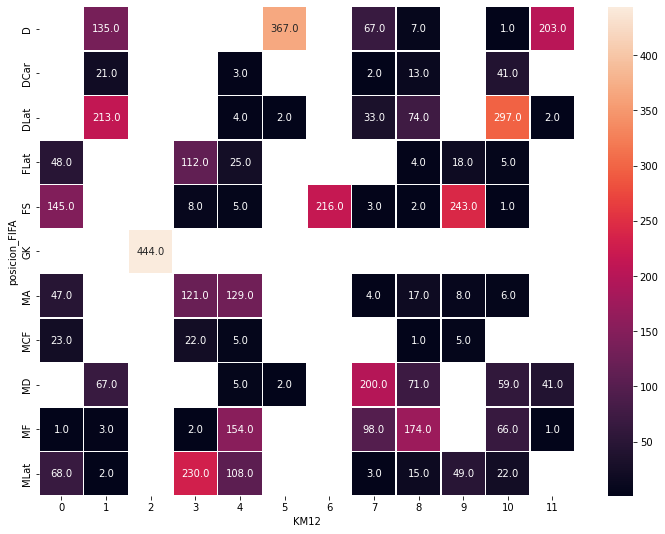

In [50]:
mapa12 = df_sk.pivot('posicion_FIFA','KM12','suma')
ax12 = plt.subplots(figsize=(12, 9))
ax12 = sns.heatmap(mapa12, annot=True, fmt="", linewidths=.5)

0 = MF
1 = GK
2 = FS
3 = MD
4 = FS
5 = D
6 = MA
7 = D
8 = DLat
9 = DLat
10 = MLat
11 = -

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

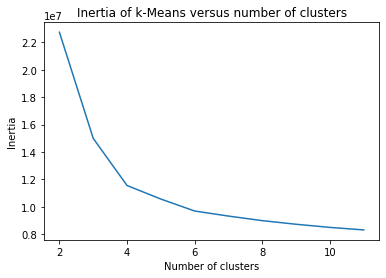

In [51]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2,12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Este grafico nos dice que usando el concepto de inercia que la cantidad optima de clusters es en torno a 4.

## 4.2-Clustering-con-Mean-Shifts

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Ejercicio: Probar con varios)

In [52]:
df_ms = pd.DataFrame(columns=['Bandwidth','Clusters'])
band = 34.0
while band < 44.5:
  ms = MeanShift(bandwidth=band, bin_seeding=True)
  ms.fit(df_skills)
  clusters2 = ms.labels_
  labels_unique = np.unique(clusters2)
  n_clusters_ = len(labels_unique)
  df_ms = df_ms.append({'Bandwidth': band,'Clusters': n_clusters_}, ignore_index=True)
  band = band+0.1
df_ms.tail(3)

,Bandwidth,Clusters
102,44.2,1.0
103,44.3,1.0
104,44.4,1.0


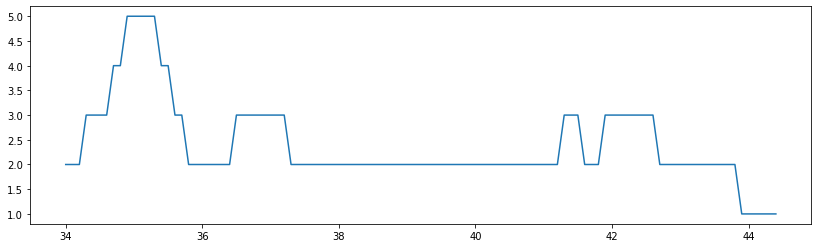

In [53]:
plt.figure(figsize=(14,4))
plt.plot(df_ms['Bandwidth'],df_ms['Clusters'])
plt.show()

El rango de bandwidth que encontramos para un numero razonable de clusters con Mean Shift es el intervalo (34.0,44.4). Fuera de este intervalo obtenemos mas de 4000 clusters, o 1 o ninguno.

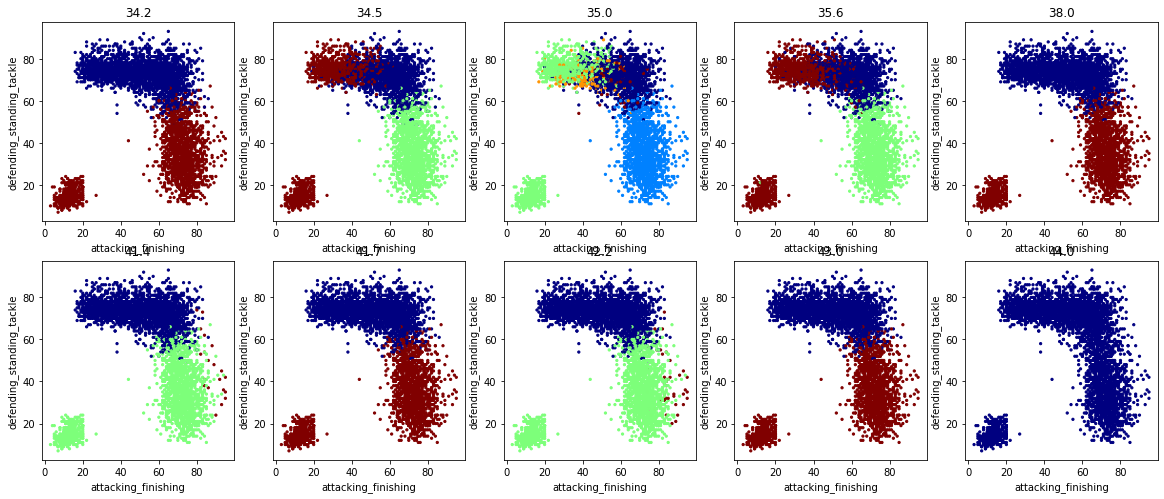

In [54]:
#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

plt.figure(figsize=(20,30))
i = 0
#for feature in [34.1,34.5,35.0,35.6,38.0,41.4,41.7,42.2,43.0,44.0]:
for band in [34.2,34.5,35.0,35.6,38.0,41.4,41.7,42.2,43.0,44.0]:
  i += 1
  ms = MeanShift(bandwidth=band, bin_seeding=True)   # 35.8-35.7   tres GK+DF; MF y FW
  ms.fit(df_skills)
  clusters2 = ms.labels_
  cluster_centers = ms.cluster_centers_
  labels_unique = np.unique(clusters2)
  n_clusters_ = len(labels_unique)

  df_temp = pd.DataFrame()
  df_temp = df_skills.copy()
  df_temp['Color'] = clusters2
  plt.subplot(7,5,i)
  plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=5,c=clusters2,cmap='jet')
  plt.xlabel(skill_1)
  plt.ylabel(skill_2)
  plt.title(band)
plt.show()

En este grafico mostramos que el intervalo de Bandwidth (34.3,35.7), los modelos con Means Shift dan resultados compatibles con los resultados obtenidos por Kmeans. En este rango obtenemos tres grandes grupos: arqueros+defensores, mediocampistas y delanteros. En los casos donde Means Shift obtiene cuatro o cinco clusters, estos clusters extras son muy poco numerosos y aislados.

In [55]:
ms = MeanShift(bandwidth=34.5, bin_seeding=True)
ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_
df_clusters['Mean Shift'] = ms.labels_ #clusters

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


In [56]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [57]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [58]:
#En Colab
fig.show(renderer="colab")

In [59]:
# Creamos una nueva variable categórica de la base recodificando la posición 
# para simplificar el análisis de los resultados de clustering

forwards=['RF','ST','LW','LF','RS','LS','RW']
midfielders=['CF','LAM','CAM','RAM','LM','LCM','CM','RM','RCM','LDM','CDM','RDM']
defenders=['GK','RCB','CB','LCB','LB','RB','RWB','LWB']
#goalkeepers=[]

def pos4(position):
    if position in forwards:
        return 'FW'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in defenders:
        return 'D'
    
#    elif position in goalkeepers:
#        return 'GK'
    
    else:
        return 'nan'

In [60]:
df_clusters["Position_red3"]=df_clusters["player_positions1"].apply(lambda x: pos4(x))
df_clusters["Position_red3"].value_counts()

D     1929
MF    1829
FW     835
Name: Position_red3, dtype: int64

In [61]:
df_sk = pd.DataFrame()
serie = df_clusters.groupby(['Position_red3','Mean Shift']).size()
df_sk = serie.to_frame().reset_index()
df_sk = df_sk.rename(columns={'Position_red3':'posicion_FIFA','Mean Shift':'MS',0:'suma'})
df_sk

,posicion_FIFA,MS,suma
0,D,0,719
1,D,2,1210
2,FW,0,26
3,FW,1,809
4,MF,0,1051
5,MF,1,711
6,MF,2,67


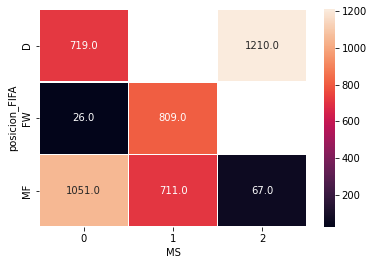

In [62]:
mapa = df_sk.pivot('posicion_FIFA','MS','suma')
ax = sns.heatmap(mapa, annot=True, fmt="", linewidths=.5)

In [63]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN, ANÁLISIS: Análisis exploratorio de los clusters, usando las clases/clusters asignadas por MeanShift** 

## 4.3-Clustering-con-DBSCAN

In [79]:
df_db = pd.DataFrame(columns=['Eps','Clusters'])
band = 1
while band < 101:
  db = DBSCAN(eps=band,min_samples=5)
  db.fit(df_skills)
  clusters3 = db.labels_
  cluster_centers = db.components_
  labels_unique = np.unique(clusters3)
  n_clusters_ = len(labels_unique)
  df_db = df_db.append({'Eps': band,'Clusters': n_clusters_}, ignore_index=True)
  band += 1

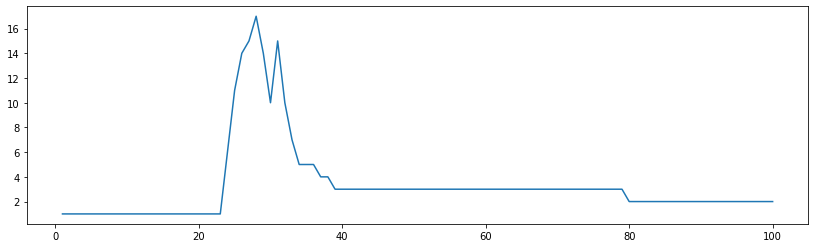

In [80]:
plt.figure(figsize=(14,4))
plt.plot(df_db['Eps'],df_db['Clusters'])
plt.show()

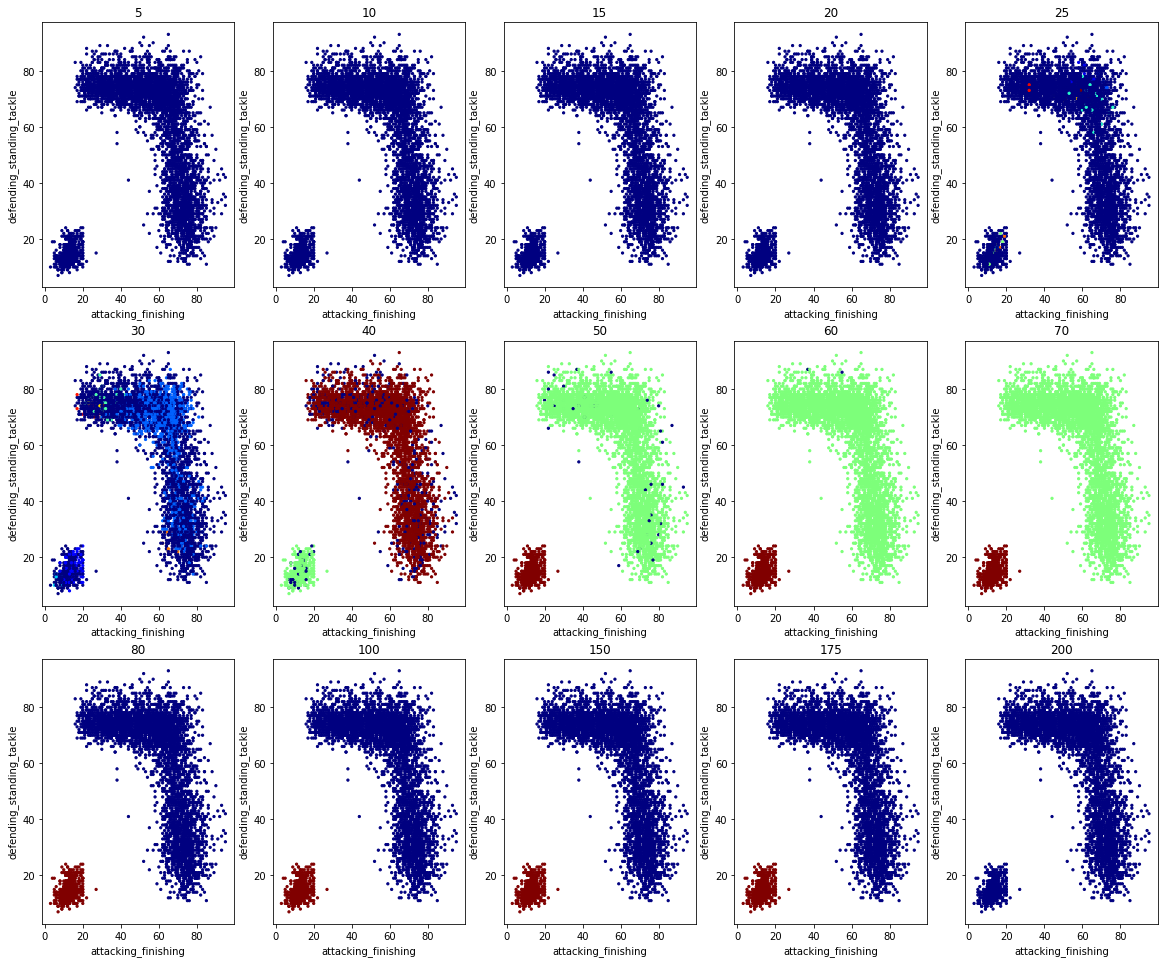

In [76]:
#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

plt.figure(figsize=(20,40))
i = 0
for band in [5,10,15,20,25,30,40,50,60,70,80,100,150,175,200]:
#for band in [5,10,15,20,25,30,60,90]:
  i += 1
  db = DBSCAN(eps=band,min_samples=5)
  db.fit(df_skills)
  clusters3 = db.labels_
  cluster_centers = db.components_
  labels_unique = np.unique(clusters3)
  n_clusters_ = len(labels_unique)

  df_temp = pd.DataFrame()
  df_temp = df_skills.copy()
  df_temp['Color'] = clusters3
  plt.subplot(7,5,i)
  plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=5,c=clusters3,cmap='jet')
  plt.xlabel(skill_1)
  plt.ylabel(skill_2)
  plt.title(band)
plt.show()

In [87]:
db = DBSCAN(eps=70,min_samples=5)

db.fit(df_skills)

clusters3 = db.labels_
cluster_centers = db.components_

labels_unique = np.unique(clusters3)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por DBSCAN : %d" % n_clusters_)

Cantidad de clusters encontrados por DBSCAN : 3


In [83]:
db = DBSCAN(eps=70,min_samples=5).fit(df_skills)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
clusters3 = db.labels_

# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(clusters3)) - (1 if -1 in clusters3 else 0)
n_clusters_ = len(np.unique(clusters3))
n_noise_ = list(clusters3).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 1


Graficamos los resultados:

In [88]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [89]:
data=[]
DBSCAN_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters3.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[DBSCAN_clusters,crack]

layout = go.Layout(title="DBSCAN",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [90]:
#En Colab
fig.show(renderer="colab")

# 5.-Clustering con dataframe de arqueros

## 5.1-Clustering-con-Kmeans


In [ ]:
# Número de clusters buscado
n_clust_arq = 2

km_arq = KMeans(n_clusters=n_clust_arq)
km_arq.fit(df_skills_arq) #utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters_arq = km_arq.labels_
#print('Suma de los cuadrados de las distancias al centro de cada cluster=Inertia= ', km.inertia_)

In [ ]:
df_clusters_arq=df_n_arq.copy()
df_clusters_arq['kmeans_5'] = km_arq.labels_ #clusters
print('Kmeans encontró: ', max(km_arq.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clusters_arq.head(4)

Kmeans encontró:  2 clusters, nosotros forzamos la cantidad


,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,kmeans_5
5,200389,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,238000000.0,NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32,35,35,35,32,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,0
7,167495,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,21,Germany,1337.0,GK,1.0,Right,4,1,5,22300000.0,NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40,43,43,43,40,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,0
8,192448,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,21,Germany,NaN,NaN,NaN,Right,4,1,4,210400000.0,NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35,38,38,38,35,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,0
12,192119,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,7,Belgium,1325.0,GK,1.0,Left,3,1,4,181700000.0,NaN,NaN,NaN,NaN,NaN,NaN,14,14,13,33,12,13,19,20,35,23,42,52,62,84,45,56,68,38,70,17,23,15,13,44,27,66,20,18,16,84,89,74,86,88,46.0,31+3,31+3,31+3,29,31,31,31,29,32+3,32+3,32+3,31+3,32+3,32+3,32+3,31+3,29+3,31+3,31+3,31+3,29+3,29+3,29+3,29+3,29+3,29+3,86+3,0


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [ ]:
bool_crack=df_n_arq["overall"] > 85
bool_no_crack=df_n_arq["overall"] < 86

#Eligo dos números entre 0 y de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
kmean_clusters_arq = go.Scatter(x=df_skills_arq[skill_1], y=df_skills_arq[skill_2],
                           mode='markers',
                           text=df_n_arq.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters_arq.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_arq.loc[bool_crack,skill_1], y=df_skills_arq.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n_arq.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters_arq,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab:
fig.show(renderer="colab")

In [ ]:
#En Jupyter:
#iplot(fig)
#plot(fig)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

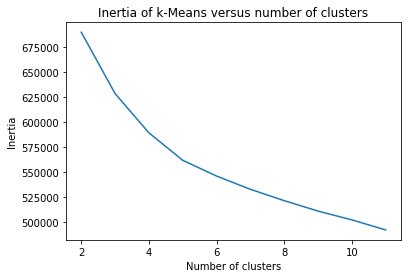

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores_arq = [KMeans(n_clusters=i).fit(df_skills_arq).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores_arq)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

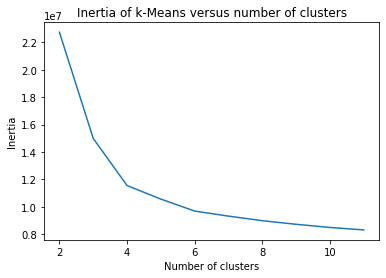

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

## 5.2-Clustering-con-Mean-Shifts

In [ ]:
ms_arq = MeanShift(bandwidth=2, bin_seeding=True)

ms_arq.fit(df_skills_arq)

clusters2 = ms_arq.labels_
cluster_centers = ms_arq.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 444


Graficamos los resultados:

In [ ]:
bool_crack=df_n_arq["overall"] > 85
bool_no_crack=df_n_arq["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[15]
skill_2=skills_ratings[24]

In [ ]:
data=[]
MeanShift_clusters_arq = go.Scatter(x=df_skills_arq[skill_1], y=df_skills_arq[skill_2],
                           mode='markers',
                        text=df_n_arq.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_arq.loc[bool_crack,skill_1], y=df_skills_arq.loc[bool_crack,skill_2],name='Top players',
                      text=df_n_arq.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters_arq,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
df_clusters_arq['MeanShift'] = ms_arq.labels_ #clusters2
print('Kmeans encontró: ', max(km_arq.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms_arq.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  2 clusters, nosotros lo forzamos
Mean shift encontró  444 clusters, según los hiperparámetros elegidos


**EVALUACIÓN, ANÁLISIS: Análisis exploratorio de los clusters, usando las clases/clusters asignadas por MeanShift** 

## 5.3-Clustering-con-DBSCAN

In [ ]:
db_arq = DBSCAN(eps=20,min_samples=2)

db_arq.fit(df_skills_arq)

clusters3 = db_arq.labels_
cluster_centers = db_arq.components_

labels_unique = np.unique(clusters3)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por DBSCAN : %d" % n_clusters_)

Cantidad de clusters encontrados por DBSCAN : 3


In [ ]:
db_arq = DBSCAN(eps=40.0,min_samples=5).fit(df_skills_arq)

core_samples_mask = np.zeros_like(db_arq.labels_, dtype=bool)
core_samples_mask[db_arq.core_sample_indices_] = True
clusters3 = db_arq.labels_

# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(clusters3)) - (1 if -1 in clusters3 else 0)
n_clusters_ = len(np.unique(clusters3))
n_noise_ = list(clusters3).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 37


Graficamos los resultados:

In [ ]:
bool_crack=df_n_arq["overall"] > 85
bool_no_crack=df_n_arq["overall"] < 86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[15]
skill_2=skills_ratings[24]

In [ ]:
data=[]
DBSCAN_clusters_arq = go.Scatter(x=df_skills_arq[skill_1], y=df_skills_arq[skill_2],
                           mode='markers',
                        text=df_n_arq.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters3.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_arq.loc[bool_crack,skill_1], y=df_skills_arq.loc[bool_crack,skill_2],name='Top players',
                      text=df_n_arq.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[DBSCAN_clusters_arq,crack]

layout = go.Layout(title="DBSCAN",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
df_clusters_arq['MeanShift'] = ms_arq.labels_ #clusters2
print('Kmeans encontró: ', max(km_arq.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms_arq.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  2 clusters, nosotros lo forzamos
Mean shift encontró  444 clusters, según los hiperparámetros elegidos


# 6.-Clustering con dataframe de jugadores de campo

## 6.1-Clustering-con-Kmeans



In [ ]:
skills_ratings_cam = ['attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle']
df_skills_cam=df_n_cam[skills_ratings_cam]

In [ ]:
# Número de clusters buscado
n_clust_cam = 5
km_cam = KMeans(n_clusters=n_clust_cam).fit(df_skills_cam) # utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters_cam = km_cam.labels_
print('Suma de los cuadrados de las distancias al centro de cada cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al centro de cada cluster=Inertia=  11553599.174627902


In [ ]:
df_clusters_cam=df_n_cam.copy()
df_clusters_cam['kmeans_5'] = km_cam.labels_ #clusters
print('Kmeans encontró: ', max(km_cam.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clusters_cam.tail(4)

Kmeans encontró:  5 clusters, nosotros forzamos la cantidad


,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,kmeans_5
4589,262411,Miguel Crespo,Miguel Crespo da Silva,CM,71,76,2800000.0,24000.0,24,183,78,326.0,Fenerbahçe SK,Turkish Süper Lig,1.0,SUB,38,Portugal,NaN,NaN,NaN,Right,3,2,1,5500000.0,67.0,64.0,70.0,72.0,68.0,79.0,66,60,62,73,58,73,73,63,70,70,69,66,74,69,65,73,67,81,77,65,83,70,68,70,66,74,61,74,69,11,8,8,15,8,NaN,67+2,67+2,67+2,69,69,69,69,69,70+2,70+2,70+2,70+2,71+2,71+2,71+2,70+2,70+2,72+2,72+2,72+2,70+2,70+2,70+2,70+2,70+2,70+2,17+2,2
4590,262815,G. Kotsiras,Giannis Kotsiras,"RB, RM",71,71,1700000.0,600.0,28,183,77,1884.0,Panathinaikos FC,Greek Super League,1.0,RB,22,Greece,NaN,NaN,NaN,Right,4,2,1,3700000.0,81.0,51.0,66.0,70.0,66.0,67.0,70,61,49,71,29,71,74,35,69,72,80,82,67,58,65,45,69,73,70,40,50,64,65,59,40,70,68,70,67,12,12,11,15,9,NaN,62+2,62+2,62+2,68,65,65,65,68,66+2,66+2,66+2,69+2,66+2,66+2,66+2,69+2,70+1,67+2,67+2,67+2,70+1,69+2,65+2,65+2,65+2,69+2,17+2,4
4591,263230,M. Osmajić,Milutin Osmajić,"ST, LM, RM",71,81,4200000.0,15000.0,21,185,76,1968.0,Cádiz CF,Spain Primera Division,1.0,SUB,15,Montenegro,NaN,NaN,NaN,Right,5,3,1,10100000.0,76.0,70.0,60.0,65.0,39.0,71.0,64,74,72,63,58,66,56,49,57,65,79,74,55,70,75,74,68,65,74,63,70,30,73,59,63,59,35,38,34,14,15,14,12,8,NaN,71+2,71+2,71+2,68,69,69,69,68,66+2,66+2,66+2,67+2,61+2,61+2,61+2,67+2,54+2,52+2,52+2,52+2,54+2,53+2,51+2,51+2,51+2,53+2,19+2,1
4592,263383,S. Lončar,Stjepan Lončar,"CDM, CAM",71,79,3900000.0,550.0,24,187,74,1874.0,Ferencvárosi TC,Hungarian Nemzeti Bajnokság I,1.0,SUB,8,Bosnia and Herzegovina,NaN,NaN,NaN,Left,3,2,1,9400000.0,61.0,62.0,67.0,71.0,65.0,73.0,57,61,54,70,61,71,60,49,74,78,59,62,53,71,55,62,61,78,72,66,72,66,68,71,48,74,64,70,61,13,10,10,6,9,NaN,66+2,66+2,66+2,67,68,68,68,67,70+2,70+2,70+2,69+2,72+2,72+2,72+2,69+2,67+2,70+2,70+2,70+2,67+2,66+2,66+2,66+2,66+2,66+2,16+2,4


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [ ]:
bool_crack=df_n_cam["overall"] > 85
bool_no_crack=df_n_cam["overall"] < 86

#Eligo dos números entre 0 y de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
kmean_clusters_cam = go.Scatter(x=df_skills_cam[skill_1], y=df_skills_cam[skill_2],
                           mode='markers',
                           text=df_n_cam.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters_cam.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_cam.loc[bool_crack,skill_1], y=df_skills_cam.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n_cam.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters_cam,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=650,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab:
fig.show(renderer="colab")

In [ ]:
#En Jupyter:
#iplot(fig)
#plot(fig)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

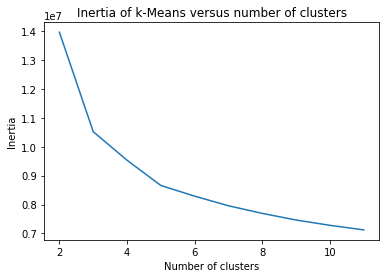

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores_cam = [KMeans(n_clusters=i).fit(df_skills_cam).inertia_ for i in range(2,12)]

plt.plot(np.arange(2,12), scores_cam)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

## 6.2-Clustering-con-Mean-Shifts

In [ ]:
ms_cam = MeanShift(bandwidth=80, bin_seeding=True)

ms_cam.fit(df_skills_cam)

clusters2 = ms_cam.labels_
cluster_centers = ms_cam.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 1


Graficamos los resultados:

In [ ]:
bool_crack=df_n_cam["overall"] > 85
bool_no_crack=df_n_cam["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
data=[]
MeanShift_clusters_cam = go.Scatter(x=df_skills_cam[skill_1], y=df_skills_cam[skill_2],
                           mode='markers',
                        text=df_n_cam.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_cam.loc[bool_crack,skill_1], y=df_skills_cam.loc[bool_crack,skill_2],name='Top players',
                      text=df_n_cam.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters_cam,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
df_clusters_cam['MeanShift'] = ms_cam.labels_ #clusters2
print('Kmeans encontró: ', max(km_cam.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms_cam.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  5 clusters, nosotros lo forzamos
Mean shift encontró  4149 clusters, según los hiperparámetros elegidos


In [ ]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Tabla de contingencia kmeans vs meanshift...
#otras ideas?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

## 6.3-Clustering-con-DBSCAN

In [ ]:
db_cam = DBSCAN(eps=20,min_samples=2)

db_cam.fit(df_skills_cam)

clusters3 = db_cam.labels_
cluster_centers = db_cam.components_

labels_unique = np.unique(clusters3)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por DBSCAN : %d" % n_clusters_)

Cantidad de clusters encontrados por DBSCAN : 26


In [ ]:
db_cam = DBSCAN(eps=30,min_samples=5).fit(df_skills_cam)

core_samples_mask = np.zeros_like(db_cam.labels_, dtype=bool)
core_samples_mask[db_cam.core_sample_indices_] = True
clusters3 = db_cam.labels_

# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(clusters3)) - (1 if -1 in clusters3 else 0)
n_clusters_ = len(np.unique(clusters3))
n_noise_ = list(clusters3).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 11
Estimated number of noise points: 2583


In [ ]:
bool_crack=df_n_cam["overall"] > 85
bool_no_crack=df_n_cam["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
data=[]
DBSCAN_clusters_cam = go.Scatter(x=df_skills_cam[skill_1], y=df_skills_cam[skill_2],
                           mode='markers',
                        text=df_n_cam.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters3.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_cam.loc[bool_crack,skill_1], y=df_skills_cam.loc[bool_crack,skill_2],name='Top players',
                      text=df_n_cam.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[DBSCAN_clusters_cam,crack]

layout = go.Layout(title="DBSCAN",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
df_clusters_cam['MeanShift'] = ms_cam.labels_ #clusters2
print('Kmeans encontró: ', max(km_cam.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms_cam.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  5 clusters, nosotros lo forzamos
Mean shift encontró  4149 clusters, según los hiperparámetros elegidos


In [ ]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["club_position"]!='GK')&(df_n['overall']>70)]

skills_ratings = ['attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle']

df_skills=df_n[skills_ratings]


In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_

In [ ]:
#data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[26]
skill_2=skills_ratings[2]

In [ ]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")